# Capstone Project 3 Machine Learning

# Background

**Context**

The dataset represents customer profiles who have left the telco company. A churn in telco and other subscription-based services means a situation when the customer leaves the service provider. 

**Target**  
1 : Customer which churn  
0 : Customer which did not churn

**Features**

1. **Dependents**: Whether the customer has dependents or not.
2. **Tenure**: Number of months the customer has stayed with the company.
3. **OnlineSecurity**: Whether the customer has online security or not.
4. **OnlineBackup**: Whether the customer has online backup or not.
5. **InternetService**: Whether the client is subscribed to Internet service.
6. **DeviceProtection**: Whether the client has device protection or not.
7. **TechSupport**: Whether the client has tech support or not 
8. **Contract**: Type of contract according to duration.
9. **PaperlessBilling**: Bills issued in paperless form.
10. **MonthlyCharges**: Amount of charge for service on monthly bases.
11. **Churn**: Whether the customer churns or not.

**Problem Statement:**

Churning customer definitely reduces company's profit as the customer stopped subscribing to company provided services.  
The company is looking to reduce the amount of churned customer as churned customer will reduce company's profit.

**Metric Evaluation:**

Type 1 error : False Positive  
Consequence : Wasting resources on customer who did not intend to churn

Type 2 error : False Negative
Consequence : Losing customer

Based on the consequences of the errors, the model needs to sensitive enough to recognize churn customers.  
The best approach might be prioritizing at reducing the amount of False Negative as possible.

### Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import shapiro

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import OrdinalEncoder

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score

from imblearn.over_sampling import SMOTEN

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier

from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import shap


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Short EDA

In [2]:
telcodata = pd.read_csv('data_telco_customer_churn.csv')
telcodata

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No
...,...,...,...,...,...,...,...,...,...,...,...
4925,No,15,No,No,Fiber optic,Yes,Yes,Month-to-month,Yes,103.45,No
4926,Yes,10,No,No,Fiber optic,Yes,Yes,Month-to-month,Yes,91.10,No
4927,No,58,No internet service,No internet service,No,No internet service,No internet service,Two year,No,20.75,No
4928,No,1,No,No,Fiber optic,No,No,Month-to-month,Yes,69.75,Yes


Checking for null or N/A values

In [3]:
telcodata.isna().sum()

Dependents          0
tenure              0
OnlineSecurity      0
OnlineBackup        0
InternetService     0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
MonthlyCharges      0
Churn               0
dtype: int64

In [4]:
telcodata.isnull().sum()

Dependents          0
tenure              0
OnlineSecurity      0
OnlineBackup        0
InternetService     0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
MonthlyCharges      0
Churn               0
dtype: int64

In [5]:
telcodata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Dependents        4930 non-null   object 
 1   tenure            4930 non-null   int64  
 2   OnlineSecurity    4930 non-null   object 
 3   OnlineBackup      4930 non-null   object 
 4   InternetService   4930 non-null   object 
 5   DeviceProtection  4930 non-null   object 
 6   TechSupport       4930 non-null   object 
 7   Contract          4930 non-null   object 
 8   PaperlessBilling  4930 non-null   object 
 9   MonthlyCharges    4930 non-null   float64
 10  Churn             4930 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 423.8+ KB


np.info did not show missing values in the dataset and the dtype of each variable is correct. This dataset are mostly populated with categorical data and only tenure and MonthlyCharges are filled with numbers, int64 for the former and float64 for the latter.

In [6]:
telcodata.describe()

,tenure,MonthlyCharges
count,4930.000000,4930.000000
mean,32.401217,64.883032
std,24.501193,29.923960
min,0.000000,18.800000
25%,9.000000,37.050000
50%,29.000000,70.350000
75%,55.000000,89.850000
max,72.000000,118.650000


In [7]:
print('Retail dataset has',telcodata.shape,'rows and columns')

Retail dataset has (4930, 11) rows and columns


In [8]:
pd.set_option('display.max_colwidth', None)
listItem = []
for column in telcodata.columns :
    listItem.append( [column, telcodata[column].nunique(), telcodata[column].unique()])


telcodataDescribe = pd.DataFrame(columns=['Column Name', 'Number of Unique Data', 'Unique Sample'], data=listItem)
telcodataDescribe

,Column Name,Number of Unique Data,Unique Sample
0,Dependents,2,"[Yes, No]"
1,tenure,73,"[9, 14, 64, 72, 3, 40, 17, 11, 8, 47, 18, 5, 1, 48, 13, 58, 7, 4, 70, 34, 31, 37, 15, 71, 10, 43, 22, 33, 69, 54, 63, 55, 66, 56, 32, 26, 24, 2, 51, 23, 49, 28, 36, 45, 42, 6, 61, 59, 67, 65, 0, 16, 52, 41, 25, 62, 20, 50, 30, 60, 19, 35, 57, 27, 44, 53, 12, 46, 39, 29, 38, 68, 21]"
2,OnlineSecurity,3,"[No, Yes, No internet service]"
3,OnlineBackup,3,"[No, Yes, No internet service]"
4,InternetService,3,"[DSL, Fiber optic, No]"
5,DeviceProtection,3,"[Yes, No internet service, No]"
6,TechSupport,3,"[Yes, No, No internet service]"
7,Contract,3,"[Month-to-month, Two year, One year]"
8,PaperlessBilling,2,"[Yes, No]"
9,MonthlyCharges,1422,"[72.9, 82.65, 47.85, 69.65, 23.6, 74.55, 19.7, 44.05, 73.5, 40.3, 33.6, 96.25, 70.45, 30.55, 44.8, 20.0, 81.5, 94.35, 35.3, 50.7, 106.05, 56.3, 20.65, 98.9, 40.2, 81.2, 19.45, 116.1, 55.2, 94.45, 84.85, 19.6, 79.0, 74.7, 30.4, 55.8, 104.5, 70.55, 55.25, 96.65, 88.85, 109.25, 104.75, 74.4, 79.4, 74.1, 73.05, 94.6, 70.35, 79.6, 79.5, 90.7, 81.0, 87.75, 118.65, 24.8, 105.25, 57.8, 19.0, 25.7, 54.2, 44.85, 19.95, 81.05, 20.35, 85.25, 67.45, 100.3, 20.95, 105.2, 26.35, 82.15, 102.6, 106.15, 23.95, 115.8, 66.85, 90.35, 89.85, 73.35, 104.45, 35.45, 88.4, 70.5, 25.1, 39.0, 83.25, 74.3, 54.3, 50.45, 86.0, 19.55, 103.5, 91.7, 64.85, 99.65, 68.75, 106.25, 75.9, 94.4, ...]"


Checking unique values of the dataset shows no missing values in the dataset

In [9]:
telcoservices = telcodata.copy()

In [10]:
telcoservices = telcoservices.drop(['Dependents','tenure','Contract','PaperlessBilling','MonthlyCharges','Churn'], axis = 1)

In [11]:
telcoservices

,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport
0,No,No,DSL,Yes,Yes
1,No,Yes,Fiber optic,Yes,No
2,Yes,No,DSL,Yes,Yes
3,Yes,Yes,DSL,Yes,Yes
4,No internet service,No internet service,No,No internet service,No internet service
...,...,...,...,...,...
4925,No,No,Fiber optic,Yes,Yes
4926,No,No,Fiber optic,Yes,Yes
4927,No internet service,No internet service,No,No internet service,No internet service
4928,No,No,Fiber optic,No,No


In [12]:
services = telcoservices.to_numpy()
services

array([['No', 'No', 'DSL', 'Yes', 'Yes'],
       ['No', 'Yes', 'Fiber optic', 'Yes', 'No'],
       ['Yes', 'No', 'DSL', 'Yes', 'Yes'],
       ...,
       ['No internet service', 'No internet service', 'No',
        'No internet service', 'No internet service'],
       ['No', 'No', 'Fiber optic', 'No', 'No'],
       ['No internet service', 'No internet service', 'No',
        'No internet service', 'No internet service']], dtype=object)

In [13]:
cos_df = []
for i in range(0, len(services)):
    count = 1
    for a in range(0,5):
        if services[i][a] == 'No':
            pass
        elif services[i][a] == 'Yes':
            count += 1
        else:
            count += 1
    cos_df.append(count)

In [14]:
cos_df = np.asarray(cos_df)
telcodata['AmountServices'] = cos_df.tolist()
telcodata

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn,AmountServices
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes,4
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No,4
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes,5
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No,6
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No,5
...,...,...,...,...,...,...,...,...,...,...,...,...
4925,No,15,No,No,Fiber optic,Yes,Yes,Month-to-month,Yes,103.45,No,4
4926,Yes,10,No,No,Fiber optic,Yes,Yes,Month-to-month,Yes,91.10,No,4
4927,No,58,No internet service,No internet service,No,No internet service,No internet service,Two year,No,20.75,No,5
4928,No,1,No,No,Fiber optic,No,No,Month-to-month,Yes,69.75,Yes,2


Adding the count of services had per each customer, the addition of count might be useful

Checking for duplicated rows in the dataset

In [15]:
dupli = telcodata.duplicated()
True in dupli

False

No duplicate rows detected in telcodata dataset

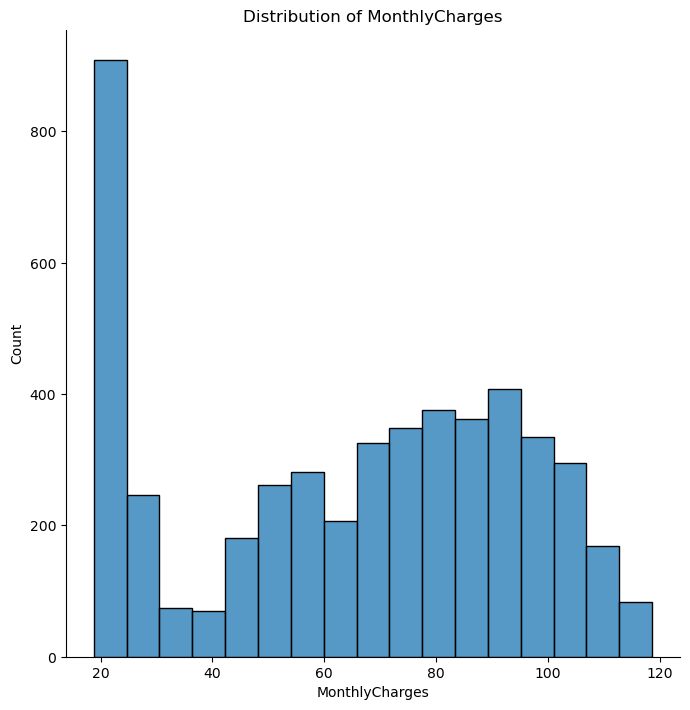

In [16]:
sns.displot(
    data = telcodata,
    x = 'MonthlyCharges',
    height = 7
).set(title = 'Distribution of MonthlyCharges')

Additional informations:
* Mean of MonthlyCharges

In [17]:
telcodata['MonthlyCharges'].mean()

64.88303245436104

* Mean of MonthlyCharges with Churned customer

In [18]:
telcodata[telcodata['Churn'] == 'Yes']['MonthlyCharges'].mean()

74.4576367781155

* Mean of MonthlyCharges with staying customer

In [19]:
telcodata[telcodata['Churn'] == 'No']['MonthlyCharges'].mean()

61.39654122855561

In [20]:
telcodata['tenure'].max()

72

In [21]:
telcodata['MonthlyCharges'].min()

18.8

In [22]:
telcodata['MonthlyCharges'].max()

118.65

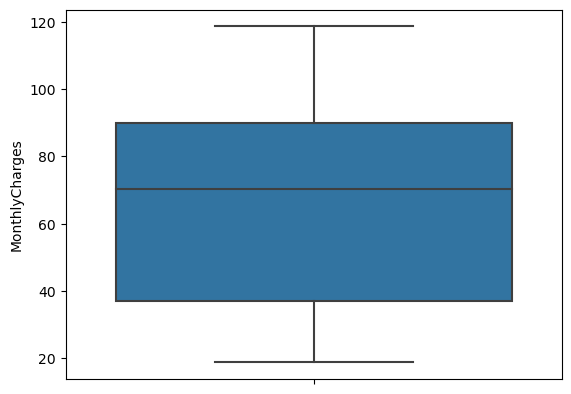

In [23]:
sns.boxplot(
    data = telcodata,
    y = 'MonthlyCharges'
)
plt.show()

Boxplot of MonthlyCharges indicates there is no outlier in the data.

In [24]:
normtest = shapiro(telcodata['MonthlyCharges'])
normtest.pvalue

1.1210387714598537e-44

MonthlyCharges is not normal distribution

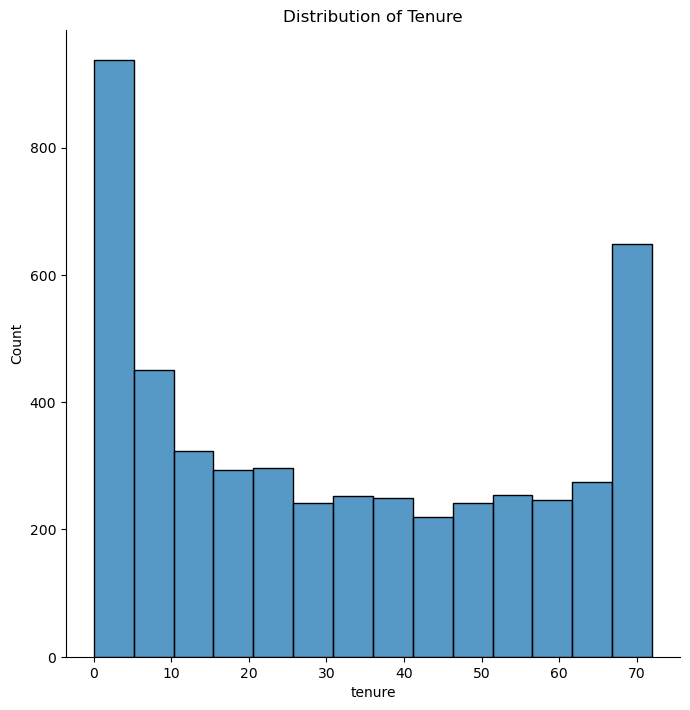

In [25]:
sns.displot(
    data = telcodata,
    x = 'tenure',
    height = 7
).set(title = 'Distribution of Tenure')
plt.show()

<Axes: xlabel='tenure'>

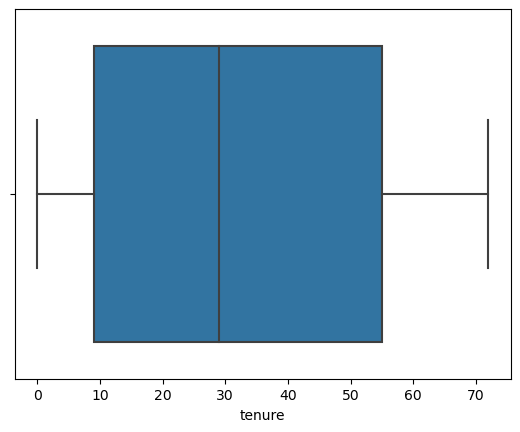

In [26]:
sns.boxplot(
    data = telcodata,
    x = 'tenure'
)

Boxplot of tenure indicates there is no outlier in the data.

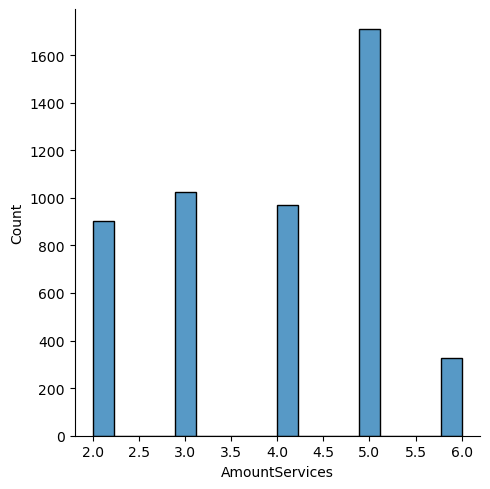

In [27]:
sns.displot(
    data = telcodata,
    x = 'AmountServices'
)

### Comparing the churn ratio
Checking the ratio of churned customer to see if the dataset is imbalanced or not.

In [28]:
len(telcodata[telcodata['Churn'] == 'Yes'])

1316

There are 1316 churned customers from the dataset

In [29]:
len(telcodata[telcodata['Churn'] == 'No'])

3614

There are 3614 customers did not churn from the dataset

In [30]:
len(telcodata[telcodata['Churn'] == 'Yes'])*100/len(telcodata[telcodata['Churn'] == 'No'])

36.413945766463755

Text(0.5, 1.0, 'Population of Churn and Staying Customer')

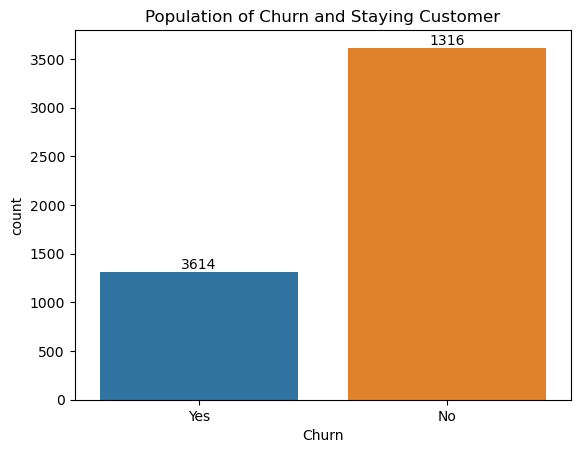

In [31]:
ax = sns.countplot(
    data = telcodata,
    x = 'Churn'
)
values = telcodata['Churn'].value_counts(ascending = False).values
ax.bar_label(container = ax.containers[0],labels = values)
plt.title('Population of Churn and Staying Customer')

The minority class which is churned customer is 36.41% of the total population inside the dataset.

According to __[Google's Machine Learning Course](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data)__ about data imbalance, the dataset is mildly imbalanced.

## Preprocess

Changing Churn values into binary, 1 for Yes and 0 for No

In [32]:
telcodata_c = telcodata.copy()
telcodata_c['Churn'] = np.where(telcodata_c['Churn'] == 'Yes',1,0)
telcodata_c

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn,AmountServices
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,1,4
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,0,4
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,1,5
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,0,6
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
4925,No,15,No,No,Fiber optic,Yes,Yes,Month-to-month,Yes,103.45,0,4
4926,Yes,10,No,No,Fiber optic,Yes,Yes,Month-to-month,Yes,91.10,0,4
4927,No,58,No internet service,No internet service,No,No internet service,No internet service,Two year,No,20.75,0,5
4928,No,1,No,No,Fiber optic,No,No,Month-to-month,Yes,69.75,1,2


In [33]:
ordinal_mapping = [
    {'col':'OnlineSecurity',
    'mapping':{
        'No internet service' : 0,
        'No' : 1, 
        'Yes' : 2, 
    }},
    {'col':'OnlineBackup',
    'mapping':{
        'No internet service' : 0,
        'No' : 1, 
        'Yes' : 2, 
    }},
    {'col':'InternetService',
    'mapping':{
        'No' : 0,
        'DSL' : 1, 
        'Fiber optic' : 2, 
    }},
    {'col':'DeviceProtection',
    'mapping':{
        'No internet service' : 0,
        'No' : 1, 
        'Yes' : 2, 
    }},
    {'col':'TechSupport',
    'mapping':{
        'No internet service' : 0,
        'No' : 1, 
        'Yes' : 2, 
    }},
    {'col':'Contract',
    'mapping':{
        'Month-to-month' : 0,
        'One year' : 1, 
        'Two year' : 2, 
    }},
]

In [34]:
onehot = OneHotEncoder(sparse = False, drop = 'first')
minmax = MinMaxScaler()
sscaler = StandardScaler()
ordi = OrdinalEncoder(mapping = ordinal_mapping)

onehotvar = ['Dependents','PaperlessBilling']
minmvar = ['tenure','MonthlyCharges']
ordivar = ['OnlineSecurity','OnlineBackup','InternetService','DeviceProtection','TechSupport','Contract']

columntransform1 = ColumnTransformer([
    ('one hot', onehot, onehotvar),
    ('scaler', minmax, minmvar),
    ('ordinal', ordi, ordivar)
])


## Data Split

In [35]:
x = telcodata_c[['Dependents','PaperlessBilling','tenure','MonthlyCharges','OnlineSecurity','OnlineBackup','InternetService','DeviceProtection','TechSupport','Contract']]
y = telcodata_c['Churn']

In [36]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    random_state = 10,
    test_size = 0.2,
    stratify = y
)

In [37]:
x_train_prep = columntransform1.fit_transform(x_train)
x_test_prep = columntransform1.fit_transform(x_test)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


### Training the models

In [38]:
regmodel = LogisticRegression(solver = 'liblinear')
regmodel.fit(x_train_prep, y_train)

LogisticRegression(solver='liblinear')

In [39]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train_prep,y_train)

KNeighborsClassifier()

In [40]:
dtree = DecisionTreeClassifier(max_depth = 5)
dtree.fit(x_train_prep, y_train)

DecisionTreeClassifier(max_depth=5)

In [41]:
gnb = GaussianNB().fit(x_train_prep, y_train)

### Cross Validation

Preeliminary performance check for the models. By using Cross Validation Score, performance of each models can be examined assumed the data used to predict is cross validated with different sections of data.

In [42]:
cvs_r = cross_val_score(regmodel,x_train_prep,y_train,scoring= 'f1')
cvs_rr = cross_val_score(regmodel,x_train_prep,y_train,scoring= 'recall')
print('Mean f1 score for Logistic Regression model : ',cvs_r.mean())
print('Mean recall score for Logistic Regression model : ',cvs_rr.mean())

Mean f1 score for Logistic Regression model :  0.5682880456523682
Mean recall score for Logistic Regression model :  0.5147280523583841


In [43]:
cvs_k = cross_val_score(knn,x_train_prep,y_train,scoring= 'f1')
cvs_kr = cross_val_score(knn,x_train_prep,y_train,scoring= 'recall')
print('Mean f1 score for KNN model : ',cvs_k.mean())
print('Mean recall score for KNN model : ',cvs_kr.mean())

Mean f1 score for KNN model :  0.5298618490191295
Mean recall score for KNN model :  0.4843511622658543


In [44]:
cvs_d = cross_val_score(dtree,x_train_prep,y_train,scoring= 'f1')
cvs_dr = cross_val_score(dtree,x_train_prep,y_train,scoring= 'recall')
print('Mean f1 score for Decision Tree model : ',cvs_d.mean())
print('Mean recall score for Decision Tree model : ',cvs_dr.mean())

Mean f1 score for Decision Tree model :  0.5364556131783534
Mean recall score for Decision Tree model :  0.46533965244865716


In [45]:
cvs_g = cross_val_score(gnb, x_train_prep, y_train, scoring = 'f1')
cvs_gr = cross_val_score(gnb, x_train_prep, y_train, scoring = 'recall')
print('Mean f1 score for GaussianNB model : ',cvs_g.mean())
print('Mean recall score for GaussianNB model : ',cvs_gr.mean())

Mean f1 score for GaussianNB model :  0.6187120763462138
Mean recall score for GaussianNB model :  0.7910810200857594


GaussianNB model performs the best when compared with other three models.  
Let's check the performance of each model with Classification Report as extra measure

In [46]:
y_pred_r = regmodel.predict(x_test_prep)
print('Classification Report for Logistic Regression Model\n',classification_report(y_test, y_pred_r,))

Classification Report for Logistic Regression Model
               precision    recall  f1-score   support

           0       0.83      0.89      0.86       723
           1       0.63      0.49      0.55       263

    accuracy                           0.79       986
   macro avg       0.73      0.69      0.70       986
weighted avg       0.77      0.79      0.78       986



In [47]:
y_pred_k = knn.predict(x_test_prep)
print('Classification Report for KNN Model\n',classification_report(y_test, y_pred_k,))

Classification Report for KNN Model
               precision    recall  f1-score   support

           0       0.82      0.89      0.86       723
           1       0.62      0.46      0.53       263

    accuracy                           0.78       986
   macro avg       0.72      0.68      0.69       986
weighted avg       0.77      0.78      0.77       986



In [48]:
y_pred_t = dtree.predict(x_test_prep)
print('Classification Report for Decision Tree\n',classification_report(y_test, y_pred_t))

Classification Report for Decision Tree
               precision    recall  f1-score   support

           0       0.82      0.89      0.85       723
           1       0.60      0.48      0.53       263

    accuracy                           0.78       986
   macro avg       0.71      0.68      0.69       986
weighted avg       0.76      0.78      0.77       986



In [49]:
y_pred_g = gnb.predict(x_test_prep)
print('Classification Report for GaussianNB Model\n',classification_report(y_test, y_pred_g))

Classification Report for GaussianNB Model
               precision    recall  f1-score   support

           0       0.91      0.73      0.81       723
           1       0.52      0.81      0.63       263

    accuracy                           0.75       986
   macro avg       0.72      0.77      0.72       986
weighted avg       0.81      0.75      0.76       986



In [50]:
models = [y_pred_r,y_pred_k,y_pred_t,y_pred_g]
index = ['LogReg','KNN','DTree','GaussNB']
columns = ['Recall Score','F1 Score']
rscore = []
f1score = []
for i in range(0,4):
    rscore.append(recall_score(y_test, models[i]))
    f1score.append(f1_score(y_test, models[i]))


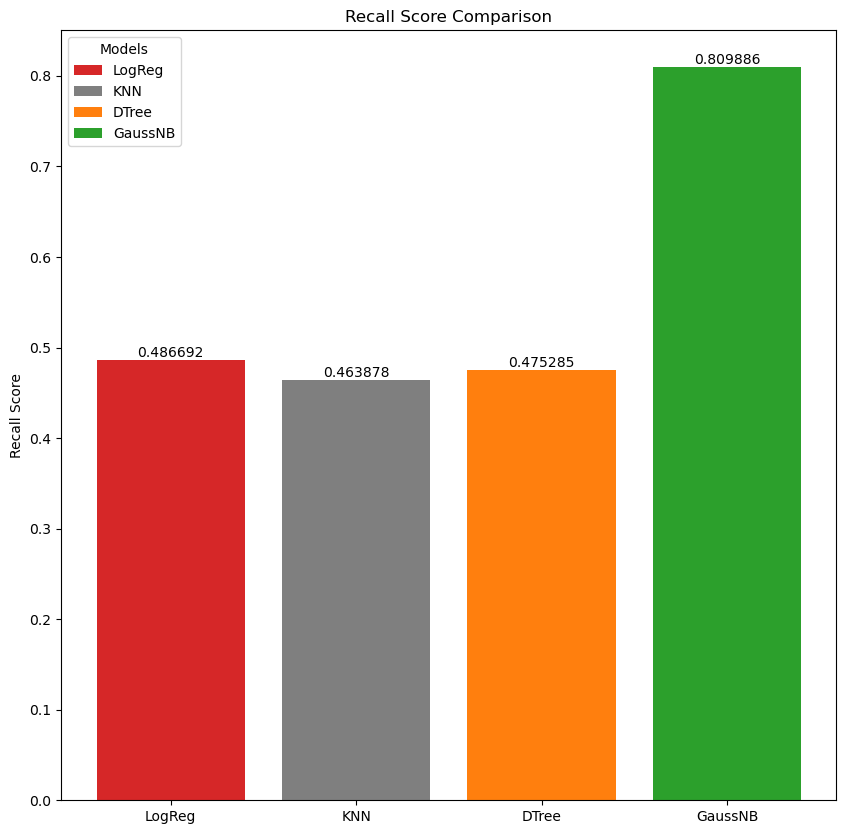

In [51]:
fig, ax = plt.subplots(figsize=(10,10))
colors = ['tab:red', 'tab:gray', 'tab:orange','tab:green']
ax.bar(index,
       rscore,
       label = index,
       color = colors
      )
ax.bar_label(ax.bar(index,
       rscore,
       color = colors
      ), label_type = 'edge')
ax.set_ylabel('Recall Score')
ax.set_title('Recall Score Comparison')
ax.legend(title = 'Models')
plt.show()

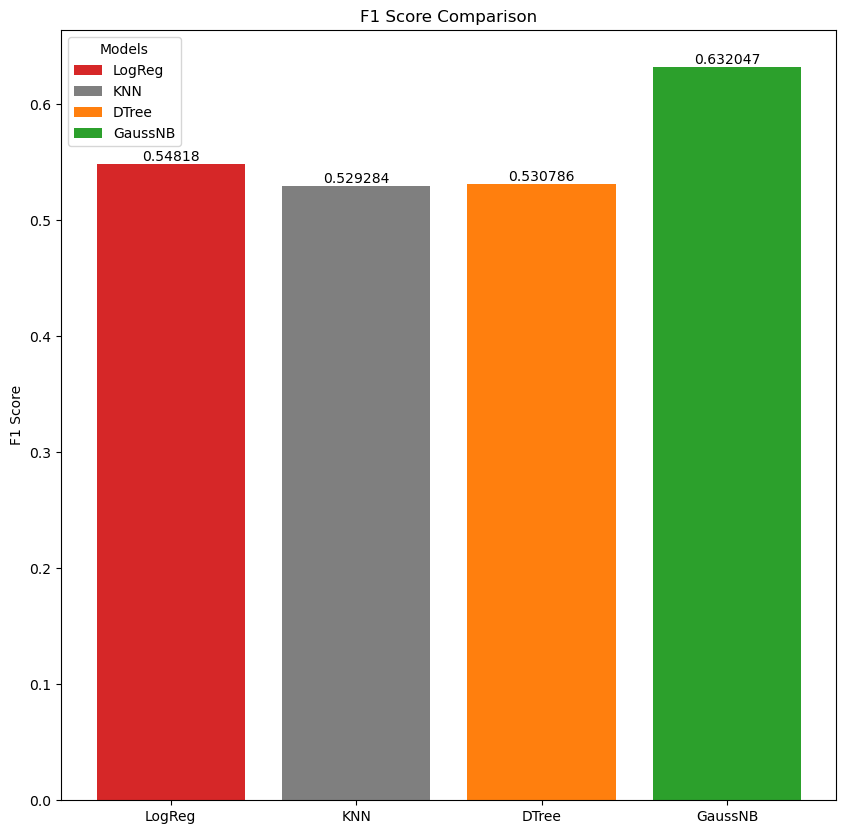

In [52]:
fig, ax = plt.subplots(figsize=(10,10))
colors = ['tab:red', 'tab:gray', 'tab:orange','tab:green']

ax.bar(index,
       f1score,
       label = index,
       color = colors,
      )
ax.bar_label(ax.bar(index,
       f1score,
       color = colors
      ), label_type = 'edge')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score Comparison')
ax.legend(title = 'Models')
plt.show()

Model built with GaussianNB has the best f1 score so the next step is to optimize the model by tuning.

### Hyperparameter Tuning

In [53]:
param = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

skfold = StratifiedKFold(n_splits= 10)
grid_search = GridSearchCV(
    gnb,
    param_grid = param, 
    verbose = 1, 
    n_jobs = -1,
    cv = skfold,
    scoring = 'f1'
)

grid_search.fit(x_train_prep, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='f1', verbose=1)

In [54]:
print('Best Score for GaussianNB model: ',grid_search.best_score_,'\nBest Parameter for GaussianNB model: ',grid_search.best_params_)

Best Score for GaussianNB model:  0.6198571965553483 
Best Parameter for GaussianNB model:  {'var_smoothing': 0.001873817422860383}


In [55]:
gnb2 = GaussianNB(var_smoothing = 0.006579332246575682)
gnb2.fit(x_train_prep, y_train)
y_pred_test = gnb.predict(x_test_prep)
print('GaussianNB with Hyperparameter Tuning \n',classification_report(y_test, y_pred_test))

GaussianNB with Hyperparameter Tuning 
               precision    recall  f1-score   support

           0       0.91      0.73      0.81       723
           1       0.52      0.81      0.63       263

    accuracy                           0.75       986
   macro avg       0.72      0.77      0.72       986
weighted avg       0.81      0.75      0.76       986



Hyperparameter tuning did not result in improvement for GaussianNB model performance.  
We will try to use Ensemble Method to try obtain a model with higher performance

# Ensemble Method

Let's try to use Ensemble method to model the telcodata dataset.

In [56]:
voting_hard = VotingClassifier(
    estimators=[('gnb', gnb),('logreg', regmodel), ('KNN', knn)],
    voting='hard'
)
voting_hard.fit(x_train_prep, y_train)

VotingClassifier(estimators=[('gnb', GaussianNB()),
                             ('logreg', LogisticRegression(solver='liblinear')),
                             ('KNN', KNeighborsClassifier())])

In [57]:
y_pred_vot = voting_hard.predict(x_test_prep)

print('Classification Report for Voting Classifier \n',classification_report(y_test, y_pred_vot))

Classification Report for Voting Classifier 
               precision    recall  f1-score   support

           0       0.85      0.86      0.86       723
           1       0.61      0.59      0.60       263

    accuracy                           0.79       986
   macro avg       0.73      0.73      0.73       986
weighted avg       0.79      0.79      0.79       986



In [58]:
gbc = GradientBoostingClassifier(n_estimators= 100,
                                 max_depth = 3
                                 ).fit(x_train_prep, y_train)

y_pred_gbc = gbc.predict(x_test_prep)
print('Classification Report for Gradient Boosting Classifier\n',classification_report(y_test, y_pred_gbc))

Classification Report for Gradient Boosting Classifier
               precision    recall  f1-score   support

           0       0.83      0.90      0.86       723
           1       0.64      0.48      0.55       263

    accuracy                           0.79       986
   macro avg       0.74      0.69      0.71       986
weighted avg       0.78      0.79      0.78       986



In [59]:
rfc = RandomForestClassifier(n_estimators= 200, max_depth= 3)
rfc.fit(x_train_prep, y_train)
y_pred_rfc = rfc.predict(x_test_prep)
print('Classification Report for Gradient Boosting Classifier\n',classification_report(y_test, y_pred_rfc))

Classification Report for Gradient Boosting Classifier
               precision    recall  f1-score   support

           0       0.80      0.94      0.87       723
           1       0.69      0.37      0.48       263

    accuracy                           0.79       986
   macro avg       0.75      0.65      0.67       986
weighted avg       0.77      0.79      0.76       986



In [60]:
models_e = [y_pred_vot, y_pred_gbc,y_pred_rfc]
index_e = ['VotingClass','GradientBoost','RForest']
columns = ['Recall Score','F1 Score']
rscore_e = []
f1score_e = []
for i in range(0,3):
    rscore_e.append(recall_score(y_test, models_e[i]))
    f1score_e.append(f1_score(y_test, models_e[i]))


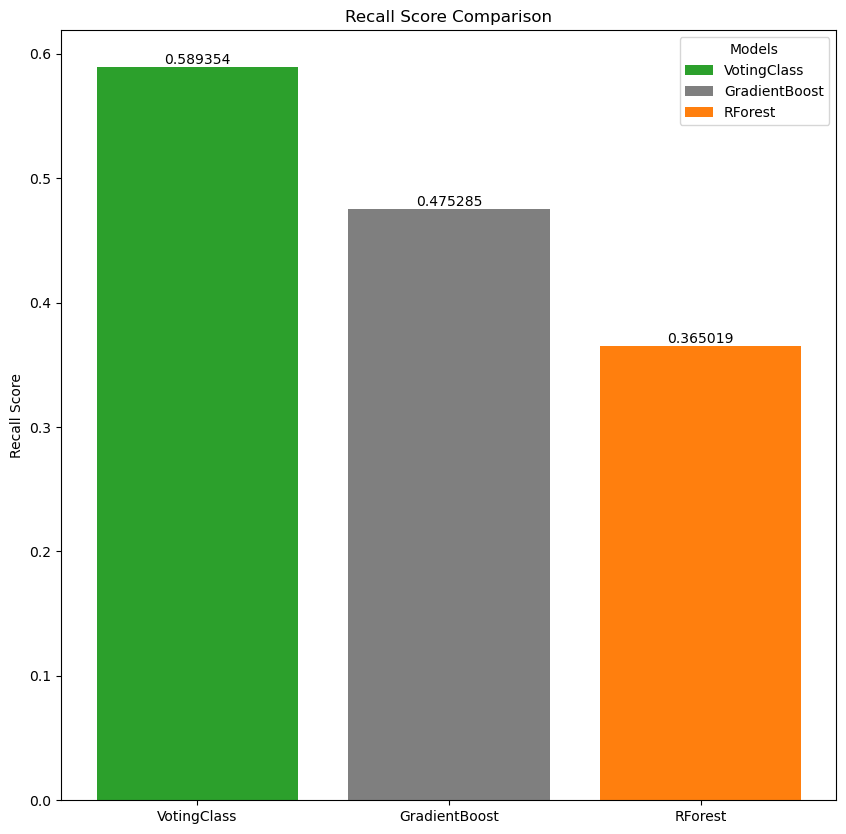

In [61]:
fig_e, ax_e = plt.subplots(figsize=(10,10))
colors_e = ['tab:green', 'tab:gray', 'tab:orange']
ax_e.bar(index_e,
       rscore_e,
       label = index_e,
       color = colors_e
      )
ax_e.bar_label(ax_e.bar(index_e,
       rscore_e,
       color = colors_e
      ), label_type = 'edge')
ax_e.set_ylabel('Recall Score')
ax_e.set_title('Recall Score Comparison')
ax_e.legend(title = 'Models')
plt.show()

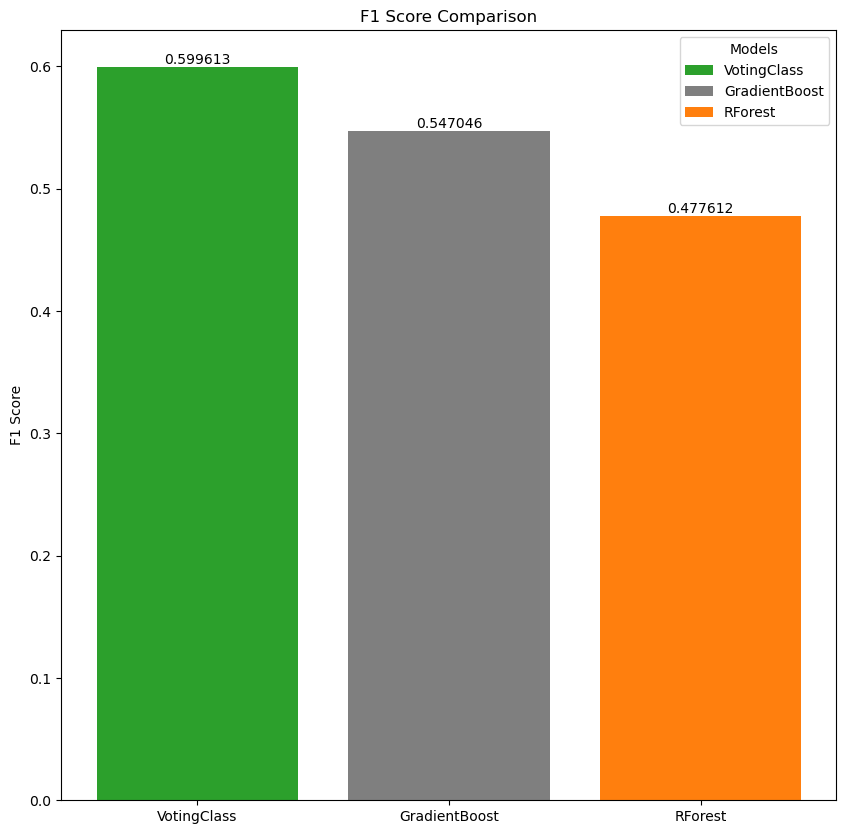

In [62]:
fig_e, ax_e = plt.subplots(figsize=(10,10))
colors_e = ['tab:green', 'tab:gray', 'tab:orange']
ax_e.bar(index_e,
       f1score_e,
       label = index_e,
       color = colors_e
      )
ax_e.bar_label(ax_e.bar(index_e,
       f1score_e,
       color = colors_e
      ), label_type = 'edge')
ax_e.set_ylabel('F1 Score')
ax_e.set_title('F1 Score Comparison')
ax_e.legend(title = 'Models')
plt.show()

## Imbalanced Classification

The telcodata dataset is midly imbalanced so this section tries to use Imbalace Classification technique to improve the model performance.

In [63]:
smote = SMOTEN(random_state = 10)
x_s, y_s = smote.fit_resample(x, y)

x_s_train, x_s_test, y_s_train, y_s_test = train_test_split(
    x_s,
    y_s,
    random_state = 10,
    test_size = 0.2,
)

x_s_train_prep = columntransform1.fit_transform(x_s_train)
x_s_test_prep = columntransform1.fit_transform(x_s_test)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [64]:
gnb = GaussianNB()
gnb.fit(x_s_train_prep, y_s_train)
y_pred_gnbs = gnb.predict(x_s_test_prep)
print('Classification Report for GaussianNB with SMOTEN\n',classification_report(y_s_test, y_pred_gnbs))

Classification Report for GaussianNB with SMOTEN
               precision    recall  f1-score   support

           0       0.80      0.68      0.74       716
           1       0.73      0.84      0.78       730

    accuracy                           0.76      1446
   macro avg       0.77      0.76      0.76      1446
weighted avg       0.77      0.76      0.76      1446



By using SMOTEN, GaussianNB model with Imbalace Classification have significant improvement over GaussianNB without Imbalance Classification

In [65]:
voting_hard = VotingClassifier(
    estimators=[('gnb', gnb),('logreg', regmodel), ('KNN', knn)],
    voting='hard'
)
voting_hard.fit(x_s_train_prep, y_s_train)
y_pred_vots = voting_hard.predict(x_s_test_prep)

print('Classification Report for Voting Classifier with SMOTEN\n',classification_report(y_s_test, y_pred_vots))

Classification Report for Voting Classifier with SMOTEN
               precision    recall  f1-score   support

           0       0.82      0.74      0.77       716
           1       0.76      0.84      0.80       730

    accuracy                           0.79      1446
   macro avg       0.79      0.79      0.79      1446
weighted avg       0.79      0.79      0.79      1446



Same as GaussianNB, Voting Classifier also had improvement in recall and f1 score.  
Both models are close in terms of performance.

GaussianNB has better recall score than Voting Classifier but Voting Classifier had better f1 score, so Voting Classifier is more likely to predict correctly although GaussianNB model are more sensitive to pick Churn customer.

### Confusion Matrix

GaussianNB

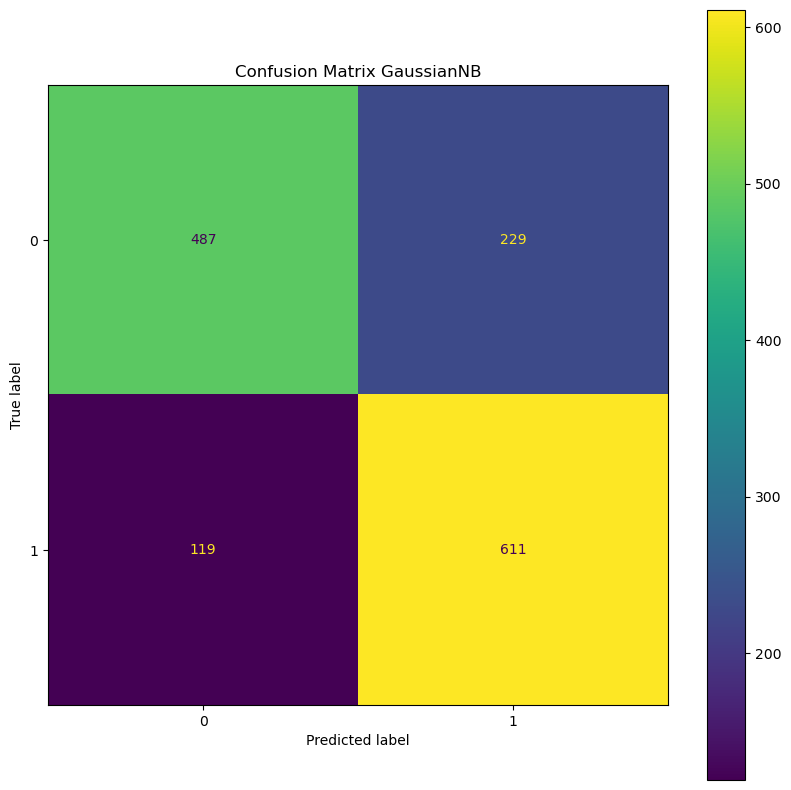

In [66]:
cm = confusion_matrix(y_s_test, y_pred_gnbs, labels = gnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = gnb.classes_)
fig, ax = plt.subplots(figsize = (10,10))
plt.title('Confusion Matrix GaussianNB')
disp.plot(ax = ax)

Voting Classifier

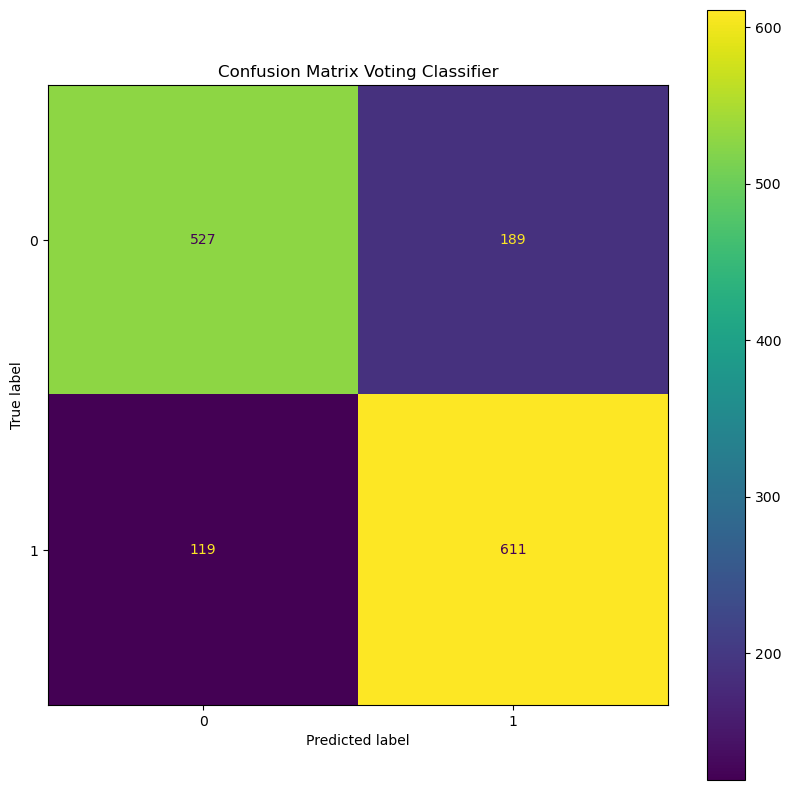

In [67]:
cm2 = confusion_matrix(y_s_test, y_pred_vots, labels = voting_hard.classes_)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels = voting_hard.classes_)
fig, ax = plt.subplots(figsize = (10,10))
plt.title('Confusion Matrix Voting Classifier')
disp2.plot(ax = ax)

### SHAP Explanation

In order to explain the model, we will use SHAP library which measures how much impact made by each features entered into model.

Preparing the DataFrame to be processed with SHAP, which requires the feature names inlcuded.

In [68]:
df = pd.DataFrame(x_s_train_prep, columns = columntransform1.get_feature_names_out())
df

,one hot__Dependents_Yes,one hot__PaperlessBilling_Yes,scaler__tenure,scaler__MonthlyCharges,ordinal__OnlineSecurity,ordinal__OnlineBackup,ordinal__InternetService,ordinal__DeviceProtection,ordinal__TechSupport,ordinal__Contract
0,0.0,1.0,0.263889,0.544817,2.0,1.0,2.0,1.0,1.0,0.0
1,1.0,1.0,0.041667,0.012519,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.375000,0.315974,2.0,1.0,1.0,1.0,1.0,0.0
3,0.0,1.0,0.166667,0.602404,2.0,1.0,2.0,1.0,1.0,0.0
4,0.0,1.0,0.569444,0.857286,1.0,2.0,2.0,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
5777,1.0,0.0,0.472222,0.595894,1.0,1.0,2.0,1.0,1.0,0.0
5778,0.0,0.0,0.166667,0.758638,1.0,1.0,2.0,1.0,1.0,0.0
5779,0.0,0.0,0.013889,0.319980,1.0,1.0,1.0,1.0,1.0,0.0
5780,0.0,1.0,0.805556,0.265398,1.0,2.0,1.0,2.0,1.0,0.0


In [69]:
shap.initjs()

In [70]:
explainer_voting = shap.Explainer(voting_hard.predict, shap.sample(x_s_test_prep, 5))
shap_values_voting = explainer_voting(df)

Exact explainer: 5783it [18:43,  5.11it/s]                          


#### SHAP Plots
Waterfall Plot

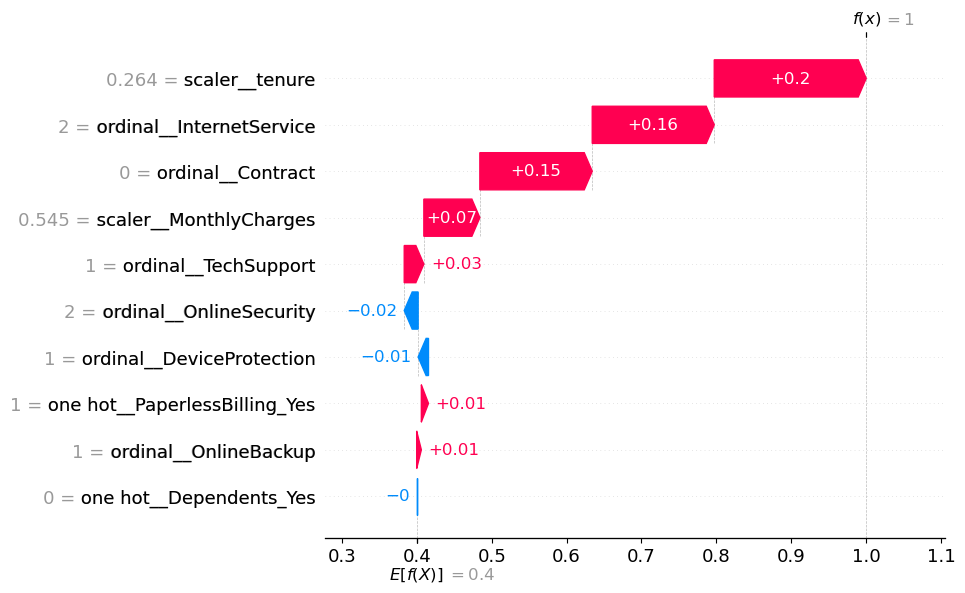

In [71]:
shap.plots.waterfall(shap_values_voting[0])

The waterfall plot shows with sample at index 0, the predicted value is f(x) = 1 and E[f(x)] is the expected value.  
Voting Classifier prediction at index 0 is highly influenced by tenure, InternetService, Contract, and MonthlyCharges features as four of these features shows the highest SHAP values from all features.  
Rest of the features (TechSupport, Online Security, etc.) did not have significant impact in prediction at index 0. Values to the left are the values for each feature at index 0.

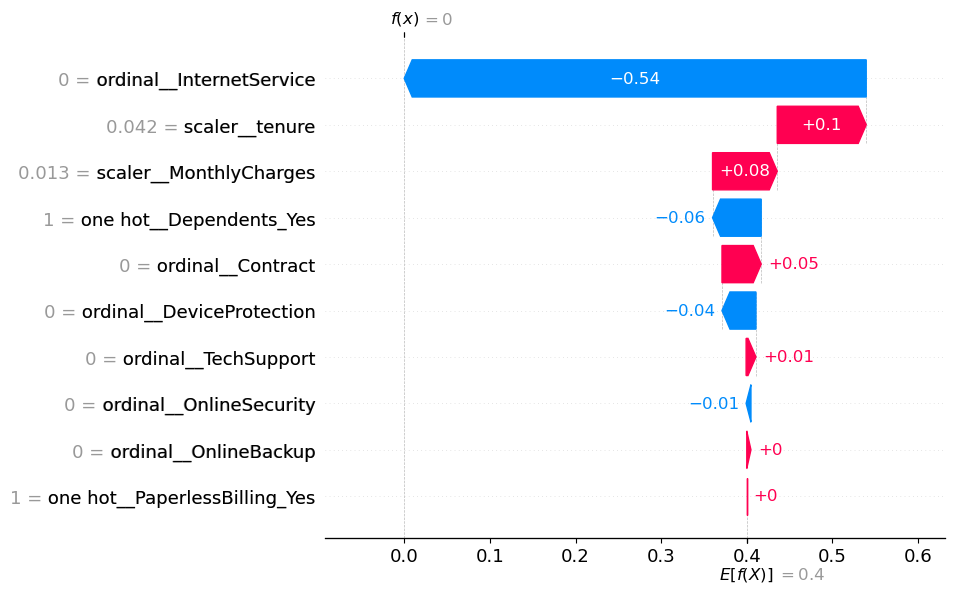

In [72]:
shap.plots.waterfall(shap_values_voting[1])

At index 1 the SHAP values of features changes, now it is InternetService which has highest impact in prediction.

In order to investigate further the impact of each feature from Voting Classifier, SHAP summary or beeswarm plot is needed.

Summary plot/Beeswarm Plot

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


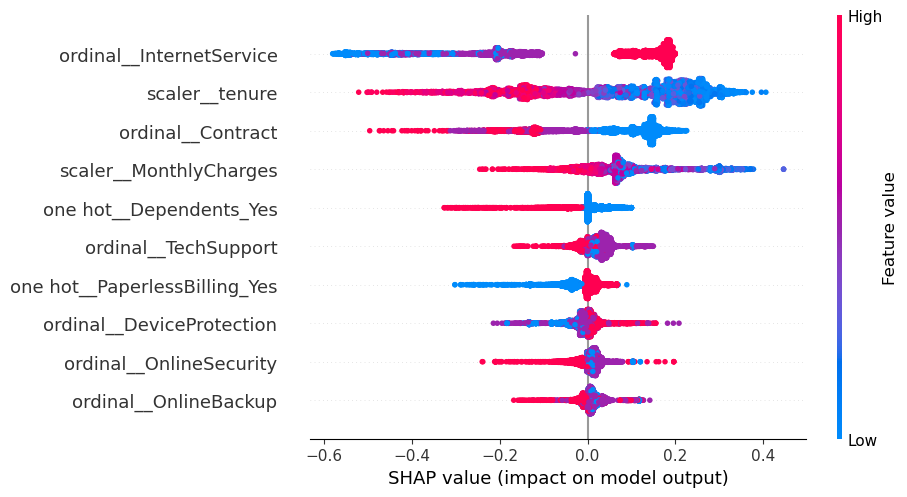

In [73]:
shap.plots.beeswarm(shap_values_voting)

In beeswarm plot or summary plot, the impact of each features measured in SHAP value are plotted from highest to lowest impact. The plot shows  InternetService, tenure, Contract and MonthlyCharges features have the highest impact in Voting Classifier model.  

Key takeaway from this plot are:
* The lower the tenure duration, the more likely the customer did not churn
* Customers with Fiber optic InternetService which have highest ordinal value are more likely to churn
* Short contract terms either month-to-month and one year customers are more likely to stay
* The more cheaper the MonthlyCharges billed to customer the more likely the customer stays

# Model Export

In [74]:
import pickle

params = {'gnb__var_smoothing': np.logspace(0,-9, num=100),
          'logreg__C': range(50,600,50),
          'knn__n_neighbors' : range(1,21)
}

grid_search_final = GridSearchCV(
    voting_hard,
    param_grid = params,
    cv = StratifiedKFold(n_splits= 10),
    scoring = 'f1',
    n_jobs = -1
)

grid_search.fit(x_s_train_prep, y_s_train)
grid_search.best_estimator_.fit(x_s_train_prep, y_s_train)
filename = 'Capstone Project 3 - Minhanz - VC Telcodata.sav'
pickle.dump(grid_search.best_estimator_,open(filename, 'wb'))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


# Conclusion & Recommendation

### Conclusion

In [75]:
print('Classification Report for Voting Classifier with SMOTEN\n',classification_report(y_s_test, y_pred_vots))

Classification Report for Voting Classifier with SMOTEN
               precision    recall  f1-score   support

           0       0.82      0.74      0.77       716
           1       0.76      0.84      0.80       730

    accuracy                           0.79      1446
   macro avg       0.79      0.79      0.79      1446
weighted avg       0.79      0.79      0.79      1446



In [76]:
print('Total of MonthlyCharges lost by Churned Customer',telcodata[telcodata['Churn'] == 'Yes']['MonthlyCharges'].sum())

Total of MonthlyCharges lost by Churned Customer 97986.25


Voting Classifier model able to pick 82% (recall score) of the customers who likely to churn and the rest of 18% is not detected, so if the model is implemented we can take action to the 82% of customers who likely to churn in order to keep the customer.

This model has  prediction accuracy of 77% (precision score) for customer who likely to churn, so if the model predicts that a customer is likely to churn, then the probability of the prediction being correct is 77%.

The total of revenue lost with churned customer is 97986.25 dollar, amounting the average lost revenue per customer is 74.45 dollar.  
The model is able to pick 82% customers and 77% of them likely to churn, assuming the customers who likely to churn are able to be kept then the potential recovered revenue is:
* 1316 (customers) x 0.82 (recall) x 0.77 (precision) x 74.45 dollar = **61793.5** dollar (rounded down to nearest integer as customer is not possible with float number)

Comparing the potential revenue saving vs. the lost revenue:
* 61793.5 x 100 / 97986.25 = **63.063%** of total lost revenue

If GaussianNB model is used then the calculation becomes:
* 1316 (customers) x 0.84 (recall) x 0.73 (precision) x 74.45 dollar = **60006.7** dollar (rounded down to nearest integer as customer is not possible with float number)
* 60006.7 x 100 / 97986.25 = **61.24%** of total lost revenue


Based on the calculations above then it can be concluded by utilizing the machine learning model built in this notebook, the company can *potentially* save 63% of lost revenue due to churn customers.

### Recommendation

The model might be able to be improved by:
* Adding more features to the dataset in order to gain more granularity in the services provided as these feature might help the model to move away from underfitting tendencies.
* Different machine learning algorithms that have not been tried in this notebook may obtain better scores, e.g. XGBoost, etc.
* Other imbalance techniques may yield better result that SMOTEN.

## Data Limitation

Voting Classifier model made in this notebook only valid for:
* Customer Tenure duration ranging from 1 month to 72 months.
* Monthly Charges ranging from 18.8 to 118.65.
* Services given by company limited 5 which are: Online Security, Online Backup, Internet Service, Device Protection, and Techincal Support (phone number subscription service is not included in this data).
* Contract terms ranging from month-to-month basis, one year basis, and two year basis.
* Internet Service limited to no internet service, DSL connection and Fiber optic connection.